In [2]:
import logging
import os

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
WORLD_SIZE = int(os.environ.get("WORLD_SIZE", 1))
DATA_URL = 'https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv'
COMPANY_NAME = 'SWKS'
FEATURE_COLS = ['open', 'high', 'low', 'close', 'volume']
TARGET_COL = 'close'
LAG = 7
EPOCHS = 150
LR = 1e-3
NO_CUDA = False
SEED = 42
LOG_PATH = ''

In [36]:
pd.read_csv(DATA_URL)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


## Utils

In [4]:
def should_distribute():
    return dist.is_available() and WORLD_SIZE > 1


def is_distributed():
    return dist.is_available() and dist.is_initialized()

## Dataset

In [24]:
def get_data(name, url=DATA_URL):
    df = pd.read_csv(url)
    df = df[df['Name'] == name]
    targets = df[TARGET_COL].values
    features = df[FEATURE_COLS].values

    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    features = feature_scaler.fit_transform(features) # Scale the data
    targets = target_scaler.fit_transform(targets.reshape(-1, 1)).squeeze()

    return features, targets, target_scaler


def process_data(features, targets, lag):
    X, Y = [], []
    lag = lag
    for i in range(len(features) - lag - 1):
        X.append(features[i: (i + lag)].reshape(1, -1))
        Y.append(targets[(i + lag)])
    return np.array(X), np.array(Y)


class StockDataset(Dataset):
    def __init__(self, X, y, train=True, test_size=0.2):
        super(StockDataset, self).__init__()
        cutoff = int((1-test_size) * len(X))
        if train:
            self.features = X[:cutoff]
            self.targets = y[:cutoff]
        else:
            self.features = X[cutoff:]
            self.targets = y[cutoff:]

        self.features = self.features.astype(np.float32)
        self.targets = self.targets.astype(np.float32)

    def __len__(self):
        assert len(self.features) == len(self.targets)
        return len(self.features)

    def __getitem__(self, item):
        return self.features[item], self.targets[item]

## RNN model

In [16]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional + 1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)

        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

## Training function

In [17]:
def train(model, device, train_loader, optimizer, loss_fn, epoch):
    model.train()
    for features, targets in train_loader:
        features, targets = features.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        optimizer.zero_grad()
        output, _ = model(features, None)
        loss = loss_fn(output.squeeze(), targets)
        loss.backward()
        optimizer.step()

    msg = "Train Epoch: {}\tloss={}".format(
        epoch, loss.item())
    logging.info(msg)

## Test function

In [18]:
def test(model, device, test_loader, loss_fn, epoch):
    model.eval()
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            output, _ = model(features, None)
            test_loss = loss_fn(output.squeeze(), targets)

    if epoch % 20 == 0:
        logging.info("{{metricName: loss, metricValue: {}}}\n".format(test_loss))

## Main function

In [19]:
def main():
    if dist.is_available():
        BACKEND = dist.Backend.GLOO

    # Use this format (%Y-%m-%dT%H:%M:%SZ) to record timestamp of the metrics.
    # If log_path is empty print log to StdOut, otherwise print log to the file.
    if LOG_PATH == "":
        logging.basicConfig(
            format="%(asctime)s %(levelname)-8s %(message)s",
            datefmt="%Y-%m-%dT%H:%M:%SZ",
            level=logging.DEBUG)
    else:
        logging.basicConfig(
            format="%(asctime)s %(levelname)-8s %(message)s",
            datefmt="%Y-%m-%dT%H:%M:%SZ",
            level=logging.DEBUG,
            filename=LOG_PATH)

    use_cuda = not NO_CUDA and torch.cuda.is_available()
    if use_cuda:
        print("Using CUDA")

    torch.manual_seed(SEED)

    device = torch.device("cuda" if use_cuda else "cpu")

    if should_distribute():
        print("Using distributed PyTorch with {} backend".format(BACKEND))
        dist.init_process_group(backend=BACKEND)

    kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

    data, scaler = get_data(name=COMPANY_NAME)
    X, y = process_data(data, LAG)

    train_dset = StockDataset(X, y, train=True)
    test_dset = StockDataset(X, y, train=False)

    train_loader = DataLoader(train_dset,
                              batch_size=len(train_dset),
                              shuffle=True,
                              **kwargs
                              )

    test_loader = DataLoader(test_dset,
                             batch_size=len(test_dset),
                             shuffle=True,
                             **kwargs,
                            )

    model = RNN(i_size=LAG,
                h_size=64,
                n_layers=3,
                o_size=1,
                bidirectional=False,
                )
    model.to(device)

    if is_distributed():
        Distributor = nn.parallel.DistributedDataParallel if use_cuda \
            else nn.parallel.DistributedDataParallelCPU
        model = Distributor(model)

    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()

    for epoch in range(1, EPOCHS + 1):
        train(model, device, train_loader, optimizer, loss_fn, epoch)
        test(model, device, test_loader, loss_fn, epoch)

In [9]:
main()

2021-10-26T14:49:27Z INFO     Train Epoch: 1	loss=0.23045894503593445
2021-10-26T14:49:28Z INFO     Train Epoch: 2	loss=0.20813706517219543
2021-10-26T14:49:29Z INFO     Train Epoch: 3	loss=0.18792681396007538
2021-10-26T14:49:29Z INFO     Train Epoch: 4	loss=0.1692219227552414
2021-10-26T14:49:30Z INFO     Train Epoch: 5	loss=0.1508132517337799
2021-10-26T14:49:31Z INFO     Train Epoch: 6	loss=0.13354389369487762
2021-10-26T14:49:33Z INFO     Train Epoch: 7	loss=0.11645235121250153
2021-10-26T14:49:34Z INFO     Train Epoch: 8	loss=0.1007850244641304
2021-10-26T14:49:35Z INFO     Train Epoch: 9	loss=0.08590594679117203
2021-10-26T14:49:36Z INFO     Train Epoch: 10	loss=0.07499672472476959
2021-10-26T14:49:37Z INFO     Train Epoch: 11	loss=0.0711047500371933
2021-10-26T14:49:37Z INFO     Train Epoch: 12	loss=0.07774487137794495


KeyboardInterrupt: 

In [25]:
if dist.is_available():
    BACKEND = dist.Backend.GLOO

# Use this format (%Y-%m-%dT%H:%M:%SZ) to record timestamp of the metrics.
# If log_path is empty print log to StdOut, otherwise print log to the file.
if LOG_PATH == "":
    logging.basicConfig(
        format="%(asctime)s %(levelname)-8s %(message)s",
        datefmt="%Y-%m-%dT%H:%M:%SZ",
        level=logging.DEBUG)
else:
    logging.basicConfig(
        format="%(asctime)s %(levelname)-8s %(message)s",
        datefmt="%Y-%m-%dT%H:%M:%SZ",
        level=logging.DEBUG,
        filename=LOG_PATH)

use_cuda = not NO_CUDA and torch.cuda.is_available()
if use_cuda:
    print("Using CUDA")

torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")

if should_distribute():
    print("Using distributed PyTorch with {} backend".format(BACKEND))
    dist.init_process_group(backend=BACKEND)

kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

features, targets, scaler = get_data(name=COMPANY_NAME)
X, y = process_data(features, targets, LAG)

train_dset = StockDataset(X, y, train=True)
test_dset = StockDataset(X, y, train=False)

train_loader = DataLoader(train_dset,
                          batch_size=len(train_dset),
                          shuffle=True,
                          **kwargs
                          )

test_loader = DataLoader(test_dset,
                         batch_size=len(test_dset),
                         shuffle=True,
                         **kwargs,
                        )

model = RNN(i_size=LAG*5,
            h_size=64,
            n_layers=3,
            o_size=1,
            bidirectional=False,
            )
model.to(device)

if is_distributed():
    Distributor = nn.parallel.DistributedDataParallel if use_cuda \
        else nn.parallel.DistributedDataParallelCPU
    model = Distributor(model)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(1, EPOCHS + 1):
    train(model, device, train_loader, optimizer, loss_fn, epoch)
    test(model, device, test_loader, loss_fn, epoch)

2021-10-26T15:41:08Z INFO     Train Epoch: 1	loss=0.28310927748680115
2021-10-26T15:41:08Z INFO     Train Epoch: 2	loss=0.25824639201164246
2021-10-26T15:41:09Z INFO     Train Epoch: 3	loss=0.23444120585918427
2021-10-26T15:41:10Z INFO     Train Epoch: 4	loss=0.21153166890144348
2021-10-26T15:41:11Z INFO     Train Epoch: 5	loss=0.18830914795398712
2021-10-26T15:41:11Z INFO     Train Epoch: 6	loss=0.16499768197536469
2021-10-26T15:41:12Z INFO     Train Epoch: 7	loss=0.1402594894170761
2021-10-26T15:41:13Z INFO     Train Epoch: 8	loss=0.11603318899869919
2021-10-26T15:41:13Z INFO     Train Epoch: 9	loss=0.09250721335411072
2021-10-26T15:41:14Z INFO     Train Epoch: 10	loss=0.07580891996622086
2021-10-26T15:41:15Z INFO     Train Epoch: 11	loss=0.07080771774053574
2021-10-26T15:41:16Z INFO     Train Epoch: 12	loss=0.08562443405389786
2021-10-26T15:41:16Z INFO     Train Epoch: 13	loss=0.09544496238231659
2021-10-26T15:41:17Z INFO     Train Epoch: 14	loss=0.08999740332365036
2021-10-26T15:41

In [29]:
features.shape

torch.Size([251, 1, 35])

In [30]:
targets.shape

torch.Size([251])

In [26]:
for features, targets in test_loader:
    hidden = None
    model.eval()
    out, _ = model(features, hidden)
    out = out.detach().cpu().numpy()

(0.0, 120.0)

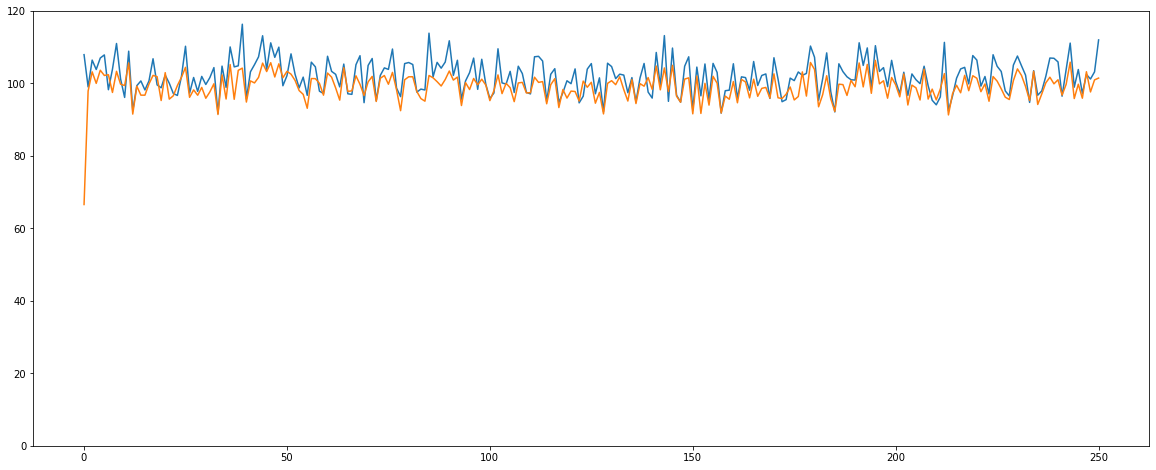

In [35]:
plt.figure(figsize=(20, 8))
plt.plot(scaler.inverse_transform(targets.reshape(-1, 1)))
plt.plot(scaler.inverse_transform(out.reshape(-1, 1)))
plt.ylim((0, 120))